##### Copyright 2019 The TensorFlow Authors.

# Fine-tuning a BERT model for Multi-Task training

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/official_models/tutorials/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
!pip install -q tf-models-official==2.3.0

### Imports

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

This section consists of all the resources that needs to be imported for Multi-Task training on BERT

We first import the configuration of a BERT model

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

In [ ]:
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

We then create a model architecture to do Multi-Task training. In this notebook, we implement Multi-Task training on two datasets from the XTREME benchmark namely PAWSX and XNLI

PAWSX stands for Paraphrase Adversaries from Word Scrambling (X for multiple languages) Given two sentences,the task involves classification of this pair as Y or N. The two sentences can have words jumbled thus altering the meaning. More details about PAWSX on https://www.aclweb.org/anthology/N19-1131.pdf

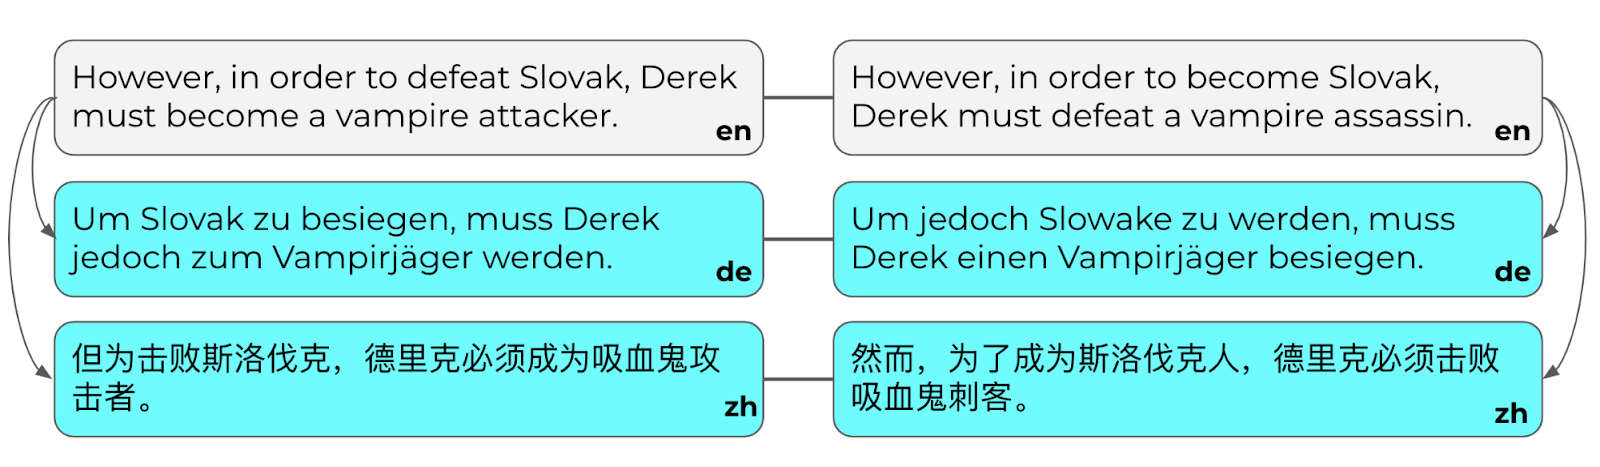

###### XNLI is a task of classifying a pair of sentences as either entailment, neutral, or contradiction. https://arxiv.org/pdf/1809.05053.pdf Source: StanfordNLP
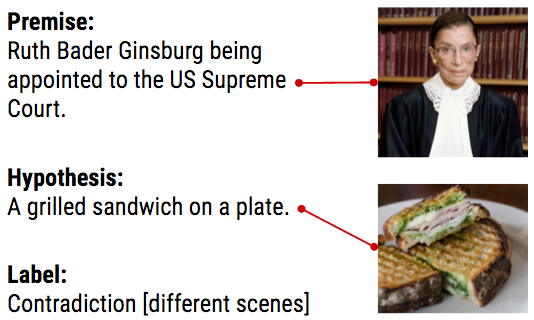

####We have two tasks - one with 2 labels and one with 3 labels. Therefore, we create two classification layers with **2 and 3 heads** respectively.

### We use Tensorflow Hub to load the BERT multicase checkpoint (https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2) and build a classification framework on top of that.

In [ ]:
max_seq_length = 128
initializer = tf.keras.initializers.TruncatedNormal(
        stddev=bert_config.initializer_range)
bert_encoder = bert.bert_models.get_transformer_encoder(
    bert_config, max_seq_length)

input_word_ids = tf.keras.layers.Input(
  shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(
  shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
input_type_ids = tf.keras.layers.Input(
  shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')

bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)
pooled_output, seq_output = bert_model([input_word_ids, input_mask, input_type_ids])
output1 = tf.keras.layers.Dropout(rate=bert_config.hidden_dropout_prob)(
  pooled_output)

output1 = tf.keras.layers.Dense(
  2, kernel_initializer=initializer, name='output1')(
      output1)

output2 = tf.keras.layers.Dropout(rate=bert_config.hidden_dropout_prob)(
  pooled_output)

output2 = tf.keras.layers.Dense(
  3, kernel_initializer=initializer, name='output2')(
      output2)

model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=[output1, output2])

##A visual plot of the model is shown below

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
!gcloud auth application-default login


####The next block calculates the ratio of size of each individual task to the size of all tasks. We use this proportion later to build a dataset that represents this proportion.

In [ ]:
tf_records_filenames = ["gs://nts2020/xtereme/pawsx/train.en.tfrecords", "gs://nts2020/xtereme/xnli/train.en.tfrecords"]

sampling_factor = []
for fn in tf_records_filenames:
    c = 0
    for record in tf.compat.v1.python_io.tf_record_iterator(fn):
        c += 1
    sampling_factor.append(c)
    print(c)
c = sum(sampling_factor)
for i in range(0, len(sampling_factor)):
    sampling_factor[i] = sampling_factor[i]/c
sampling_factor

#### Setup the Optimizer based on the size of the data

In [ ]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = c
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

This returns an `AdamWeightDecay`  optimizer with the learning rate schedule set:

In [ ]:
type(optimizer)

#### Next, we use Tensorflow's existing data creation utility functions to create TFdatasets from TFrecords. The main difference here is we add a new parameter *task_id* to return datasets of the format *(x, (y1,y2,...)* as opposed to just *(x,y)* in the case of single-task setting.

In [ ]:
def single_file_dataset(input_file, name_to_features, num_samples=None):
  """Creates a single-file dataset to be passed for BERT custom training."""
  # For training, we want a lot of parallel reading and shuffling.
  # For eval, we want no shuffling and parallel reading doesn't matter.
  d = tf.data.TFRecordDataset(input_file)
  if num_samples:
    d = d.take(num_samples)
  d = d.map(
      lambda record: decode_record(record, name_to_features),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # When `input_file` is a path to a single file or a list
  # containing a single path, disable auto sharding so that
  # same input file is sent to all workers.
  if isinstance(input_file, str) or len(input_file) == 1:
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = (
        tf.data.experimental.AutoShardPolicy.OFF)
    d = d.with_options(options)
  return d

In [ ]:
def decode_record(record, name_to_features):
  """Decodes a record to a TensorFlow example."""
  example = tf.io.parse_single_example(record, name_to_features)

  # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
  # So cast all int64 to int32.
  for name in list(example.keys()):
    t = example[name]
    if t.dtype == tf.int64:
      t = tf.cast(t, tf.int32)
    example[name] = t

  return example

#### We start with 2 tasks, therefore the create_classifier_dataset function is coded to return **(X, (Y1,Y2))**. A label of **-1** is returned for **Ys** that doesn't belong to a particular **X**.  This can be extended to multiple tasks.

In [ ]:
def create_classifier_dataset(file_path,
                              seq_length,
                              batch_size,
                              task_id,
                              is_training=True,
                              input_pipeline_context=None,
                              label_type=tf.int64,
                              include_sample_weights=False,
                              num_samples=None):
  """Creates input dataset from (tf)records files for train/eval."""
  name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([], label_type),
  }
  if include_sample_weights:
    name_to_features['weight'] = tf.io.FixedLenFeature([], tf.float32)
  dataset = single_file_dataset(file_path, name_to_features,
                                num_samples=num_samples)

  # The dataset is always sharded by number of hosts.
  # num_input_pipelines is the number of hosts rather than number of cores.
  if input_pipeline_context and input_pipeline_context.num_input_pipelines > 1:
    dataset = dataset.shard(input_pipeline_context.num_input_pipelines,
                            input_pipeline_context.input_pipeline_id)

  def _select_data_from_record(record):
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    #pdb.set_trace()
    y = record['label_ids']
    if include_sample_weights:
      w = record['weight']
      return (x, y, w)
    default = tf.constant(-1, dtype=tf.int32)
    if task_id ==0:
      return (x, (y, default))
    if task_id == 1:
      return (x, (default,y))

  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

#### PAWSX and XNLI training and eval set is loaded seperately. Important to mark **is_training = False** when creating the eval set as the dataset should not be repeated. More on XTREME https://arxiv.org/abs/2003.11080

In [ ]:
paws_training_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/pawsx/train.en.tfrecords",
    128,
    batch_size,
    task_id = 0,
    is_training=True)

xnli_training_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/xnli/train.en.tfrecords",
    128,
    batch_size,
    task_id =1,
    is_training=True)

In [ ]:
paws_eval_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/pawsx/eval.en.tfrecords",
    128,
    batch_size,
    task_id = 0,
    is_training=False)
xnli_eval_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/xnli/eval.en.tfrecords",
    128,
    batch_size,
    task_id = 1,
    is_training=False)

#### We sample data points from individual tasks at the sampling rate determined earlier to form the training set and evaluation set

In [ ]:
training_dataset = tf.data.experimental.sample_from_datasets(
    [paws_training_dataset, xnli_training_dataset], weights=tf.constant([sampling_factor[0], sampling_factor[1]])
)

In [ ]:
paws_eval_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/pawsx/eval.en.tfrecords",
    max_seq_length,
    batch_size,
    task_id = 0,
    is_training=False)
xnli_eval_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/xnli/eval.en.tfrecords",
    max_seq_length,
    batch_size,
    task_id =1,
    is_training=False)

In [ ]:
evaluation_dataset = tf.data.experimental.sample_from_datasets(
    [paws_eval_dataset, xnli_eval_dataset], weights=tf.constant([sampling_factor[0], sampling_factor[1]])
)

In [ ]:
training_dataset = training_dataset.batch(batch_size)
evaluation_dataset = evaluation_dataset.batch(batch_size)

#### We write a modified loss function that calculates the loss accordingly based on the task type. A line-by-line trace for the XNLI task is provided below for further clarification.



In [ ]:
#num_labels =3 y_pred.shape = (None,3)
#log_probs.shape=(None, 3)
#log_probs.shape = (None,3)
#labels.shape = (None,) y_true.shape = (None,1)
#one_hot_labels.shape = (None,3)
#per_example_loss.shape = (None,)
#loss.shape = ()

In [ ]:
def _loss_with_filter(y_true, y_pred):
  num_labels = y_pred.get_shape().as_list()[-1]
  log_probs = tf.nn.log_softmax(y_pred, axis=-1)
  log_probs = tf.reshape(log_probs, [-1, num_labels])
  labels = tf.reshape(y_true, [-1])
  one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
  per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
  loss = tf.reduce_mean(per_example_loss)
  return loss

In [ ]:
import pdb
import tensorflow.keras.backend as K

#### We also write a custom accuracy function to calculate the accuracy only for which the labels are not -1 (The task in hand for the current data point being visited)

In [ ]:
def accuracy_mod(y_true, y_pred):
  # Squeeze the shape to (None, ) from (None, 1) as we want to apply operations directly on y_true
  if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)

  # Normalize the y_pred values first and then take the arg at which we have a maximum value (This is the predicted label)
  y_pred = K.softmax(y_pred, axis = -1)
  y_pred = K.argmax(y_pred, axis = -1)

  # Since the ground labels can also have -1s for which we don't wanna calculate accuracy, we are filtering them off
  defa = K.constant([0], dtype=tf.float32)
  #Creating a boolean tensor for labels greater or equal to 0
  is_valid = K.greater_equal(y_true, defa)
  #Get the corresponding indices
  indices = tf.where(is_valid)

  #Gather the results of y_true and y_pred at the indices we calculated above
  fil_y_true = K.gather(y_true, K.reshape(indices, [-1])) 
  fil_y_pred = K.gather(y_pred, K.reshape(indices, [-1]))
  # K.print_tensor(res, message='res = ')
  # K.print_tensor(comp, message='comp = ')

  fil_y_true = K.cast(fil_y_true, K.floatx())
  fil_y_pred = K.cast(fil_y_pred, K.floatx())

  #pdb.set_trace()
  return K.cast(K.equal(fil_y_true, fil_y_pred), K.floatx())


In [ ]:

metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer = optimizer, loss = [_loss_with_filter, _loss_with_filter], metrics = [accuracy_mod])

In [ ]:
model.fit(training_dataset, batch_size = batch_size, epochs= 3, steps_per_epoch = 1000, validation_data=evaluation_dataset)